# Homework 04: Word Vectors

## Submission Instructions:
1. Once the notebook is completed, **RESTART THE KERNEL AND RUN ALL CELLS**, save it and submit it. 
2. DO NOT submit the data from the assignment.
3. Whenever we ask to .head(10) the results or print out a value, please use `print()` so for example `print(df.head(10))`. Print only the answers to the questions that have been asked.  Do not print the head of a dataset unless explicitly asked. 
4. Whenever displaying a graph use `plt.show()`
5. For theoretical answers/short answers, use print() (e.g., print("your answer")).
6. Wherever we have code displayed to print out values, use that code as a template to print out your output.  For example, if we give you `print(f'Threshold for best accuracy: {}')` please use code in this style to print out your output.

In [5]:
import pandas as pd
import numpy as np
import time
import dill
import nltk
import json
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Ensure nltk stopwords and wordnet are downloaded if not already:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt_tab')

from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from nltk.stem import PorterStemmer
from tokenizers import Tokenizer, models, trainers
from tokenizers.normalizers import NFD, Lowercase, StripAccents, Sequence
from tokenizers.pre_tokenizers import Whitespace




### Question 1

Load your JSON data (from Homework 02) into a pandas dataframe

In [21]:
with open("data.json", 'r') as file:
        data = json.load(file)
    

In [22]:
df = pd.DataFrame(data)

### Question 2

Text Cleaning: Implement a clean_text function for job descriptions that:
- Removes the text from the HTML
- Lowercases text	
- Removes punctuation and numbers	
- Tokenizes into words	
- Removes stopwords
- Applies lemmatization
- Returns the description as a list of strings (not 1 big string)

In [24]:

STOPWORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()

def strip_html(text: str) -> str:

    soup = BeautifulSoup(text, "html.parser")
    for tag in soup(["script", "style"]):
        tag.decompose()
    return soup.get_text(separator=" ")

def clean_text(text: str) -> list[str]:

    if not isinstance(text, str):
        return []
    text = strip_html(text)

    text = text.lower()

    text = re.sub(r"[^a-z0-9\s]", " ", text)


    tokens = text.split()

    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 2]


    tokens = [LEMMATIZER.lemmatize(t) for t in tokens]


    return tokens




In [25]:
df["tokens"] = df["job_description"].apply(clean_text)

print(df[["job_description", "tokens"]].head())

                                     job_description  \
0  <p><b>Work Location:</b></p>Mount Laurel, New ...   
1  <p>DUTIES ANNUAL SALARY: $121,813 to $178,085 ...   
2  <div><div><p><b>Title:</b>  Managing Consultan...   
3  <p>Company Overview With 80,000 customers acro...   
4  <div> <div>  Job Details </div> <div>  <div>  ...   

                                              tokens  
0  [work, location, mount, laurel, new, jersey, u...  
1  [duty, annual, salary, 121, 813, 178, 085, sal...  
2  [title, managing, consultant, data, architectu...  
3  [company, overview, 000, customer, across, 150...  
4  [job, detail, job, location, loveland, positio...  


### Question 3

Show an example before-and-after cleaning for one posting.	

In [26]:

raw_text = df["job_description"].iloc[0]

In [27]:

cleaned_tokens = clean_text(raw_text)

In [28]:
raw_text



"<p><b>Work Location:</b></p>Mount Laurel, New Jersey, United States of America<p></p><p><b>Hours:</b></p>40<p></p><p><b>Pay Details:</b></p>$68,640 - $112,320 USD<p></p><p>TD is committed to providing fair and equitable compensation opportunities to all colleagues. Growth opportunities and skill development are defining features of the colleague experience at TD. Our compensation policies and practices have been designed to allow colleagues to progress through the salary range over time as they progress in their role. The base pay actually offered may vary based upon the candidate's skills and experience, job-related knowledge, geographic location, and other specific business and organizational needs.</p><p></p><p>As a candidate, you are encouraged to ask compensation related questions and have an open dialogue with your recruiter who can provide you more specific details for this role.</p><p></p><p><b>Line of Business:</b></p>Enterprise Enabling Functions<p><b>Job Description:</b></p

In [29]:
cleaned_tokens

['work',
 'location',
 'mount',
 'laurel',
 'new',
 'jersey',
 'united',
 'state',
 'america',
 'hour',
 'pay',
 'detail',
 '640',
 '112',
 '320',
 'usd',
 'committed',
 'providing',
 'fair',
 'equitable',
 'compensation',
 'opportunity',
 'colleague',
 'growth',
 'opportunity',
 'skill',
 'development',
 'defining',
 'feature',
 'colleague',
 'experience',
 'compensation',
 'policy',
 'practice',
 'designed',
 'allow',
 'colleague',
 'progress',
 'salary',
 'range',
 'time',
 'progress',
 'role',
 'base',
 'pay',
 'actually',
 'offered',
 'may',
 'vary',
 'based',
 'upon',
 'candidate',
 'skill',
 'experience',
 'job',
 'related',
 'knowledge',
 'geographic',
 'location',
 'specific',
 'business',
 'organizational',
 'need',
 'candidate',
 'encouraged',
 'ask',
 'compensation',
 'related',
 'question',
 'open',
 'dialogue',
 'recruiter',
 'provide',
 'specific',
 'detail',
 'role',
 'line',
 'business',
 'enterprise',
 'enabling',
 'function',
 'job',
 'description',
 'business',
 'an

### Question 4

Word Frequency Analysis: Count the top 50 most frequent words across all cleaned job descriptions. Plot these in a labeled bar chart with the words on the y axis	

In [30]:
all_tokens = [tok for toks in df["tokens"] for tok in toks]

freq = Counter(all_tokens)

top_50 = freq.most_common(50)

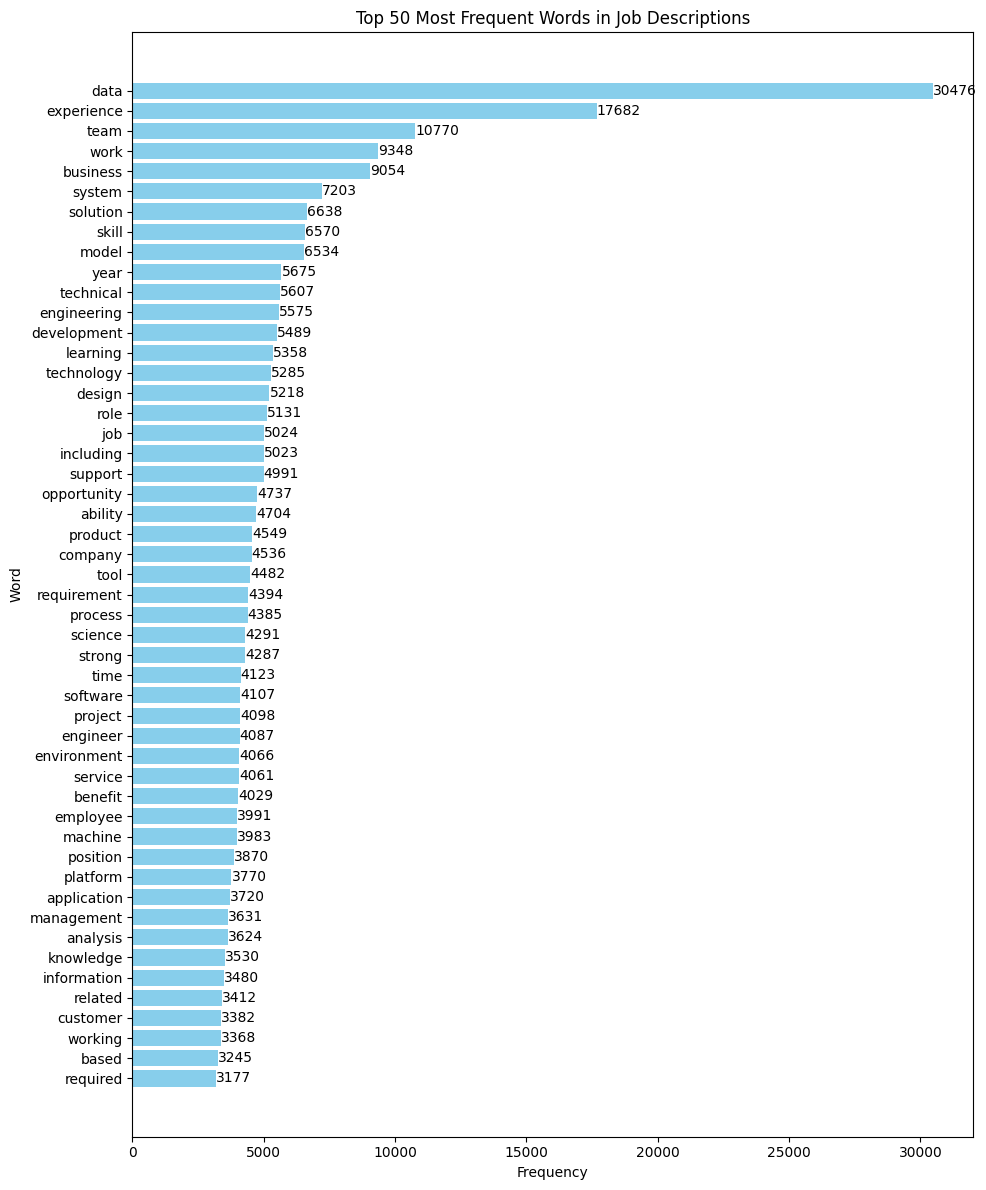

In [31]:

words, counts = zip(*top_50)

plt.figure(figsize=(10, 12))
plt.barh(words, counts, color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 50 Most Frequent Words in Job Descriptions")

plt.gca().invert_yaxis()
for i, c in enumerate(counts):
    plt.text(c + 0.5, i, str(c), va="center")

plt.tight_layout()
plt.show()

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Question 5

TF-IDF Representation: Use scikit-learn’s TfidfVectorizer to represent all job descriptions as TF-IDF vectors. Print the shape of the TF-IDF matrix (number of jobs × number of terms).	

In [34]:
df["clean_text_str"] = df["tokens"].apply(lambda toks: " ".join(toks))

tfidf = TfidfVectorizer()

X_tfidf = tfidf.fit_transform(df["clean_text_str"])

print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (3000, 23933)


### Question 6

For one posting, print the top 10 words with the highest TF-IDF scores (show both words and their scores).

In [36]:

doc_index = 0
row = X_tfidf[doc_index]

row_array = row.toarray().ravel()


terms = tfidf.get_feature_names_out()

top_indices = row_array.argsort()[::-1][:10]

print(f"Top 10 TF-IDF words for job posting {doc_index}:")
for i in top_indices:
    print(f"{terms[i]}: {row_array[i]:.4f}")


Top 10 TF-IDF words for job posting 0:
project: 0.2891
business: 0.2833
occasional: 0.2083
never: 0.1988
requirement: 0.1957
colleague: 0.1805
contributes: 0.1526
change: 0.1458
stakeholder: 0.1424
identifies: 0.1336


### Question 7

Calculate the cosine similarity between all job postings using tfidf vectors.  There is a handy cosine_similarity function in `sklearn.metrics.pairwise`.  If you pass it the tf-idf matrix, it will calculate all pairs of cosine_similarities for you.  You just have to figure out how to:
1. Remove duplicate comparisons (don't need to include the similarity between 'a' and 'b' if you already have the similarity of 'b' and 'a')
2. Remove comparisons of each description with itself.

The cosine_similarity matrix with the tfidf matrix should produce a 3000 x 3000 matrix of cosine similarities (because you have 3000 job descriptions).  This is just like a correlation matrix.  The matrix is symmetrical around the diagonal with the diagonal being all 1's.  Essentially for the 2 points above, you should ignore the cosine similarities above the diagonal (point 1) and on the diagonal (point 2)

In [37]:
from sklearn.metrics.pairwise import cosine_similarity


In [39]:

S = cosine_similarity(X_tfidf, X_tfidf)
print("Cosine-similarity matrix shape:", S.shape)  

n = S.shape[0]
i_idx, j_idx = np.tril_indices(n, k=-1)            
pairs = pd.DataFrame({
    "doc_i": i_idx,
    "doc_j": j_idx,
    "cosine_similarity": S[i_idx, j_idx],
})

pairs_sorted = pairs.sort_values("cosine_similarity", ascending=False)




Cosine-similarity matrix shape: (3000, 3000)


### Question 8

Display the top 10 most similar job posting ids

In [40]:
pairs_sorted.head(10)

,doc_i,doc_j,cosine_similarity
2476284,2225,2084,1.0
416327,912,911,1.0
18043,190,88,1.0
15503,176,103,1.0
630002,1122,1121,1.0
1393612,1669,1666,1.0
7259,120,119,1.0
354060,841,840,1.0
8506,130,121,1.0
1560260,1766,1765,1.0


### Question 9

Are there any job descriptions that are the same (have a cosine similarity of 1)?  Why would this be?  Is our jid not unique?

In [41]:

print('Yes, there are job descriptions with cosine similarity = 1, meaning they are duplicates. This happens because \n The same description can be posted under different job IDs (so jid is not unique to the text) \n Or text differences were removed during cleaning, making them identical.')

Yes, there are job descriptions with cosine similarity = 1, meaning they are duplicates. This happens because 
 The same description can be posted under different job IDs (so jid is not unique to the text) 
 Or text differences were removed during cleaning, making them identical.


### Question 10

Pick one "Data Scientist" and one "Business Analyst" posting and their cosine scores.  Describe how you selected them (job title, search result, etc....you choose).

In [42]:

ds_idx = df.index[
    df["search"].astype(str).apply(lambda s: "data" in s.lower() and "scientist" in s.lower())
][0]

ba_idx = df.index[
    df["search"].astype(str).apply(lambda s: "business" in s.lower() and "analyst" in s.lower())
][0]


print("Data Scientist:", df.loc[ds_idx, "search"], "| index:", ds_idx)
print("Business Analyst:", df.loc[ba_idx, "search"], "| index:", ba_idx)
print("Cosine similarity:", float(S[ds_idx, ba_idx]))


Data Scientist: ['Data_Scientist'] | index: 24
Business Analyst: ['Business_Analyst', 'Business_Analyst'] | index: 0
Cosine similarity: 0.10447141322661282


In [50]:
print("I selected one job posting with the title “Data Scientist” by searching the job_title column for that string, and one posting with the title “Business Analyst” in the same way. \n I then looked up their cosine similarity in the TF-IDF similarity matrix computed earlier.")

I selected one job posting with the title “Data Scientist” by searching the job_title column for that string, and one posting with the title “Business Analyst” in the same way. 
 I then looked up their cosine similarity in the TF-IDF similarity matrix computed earlier.


### Question 11

Compute and report the cosine similarity between their TF-IDF vectors.	Briefly answer what this score means and why these two postings are so similar.

In [45]:

print(f"Cosine similarity (Data Scientist vs Business Analyst): {cos_score:.4f}")

if cos_score >= 0.7:
    why = "High similarity — likely near-duplicates or shared template/stack."
elif cos_score >= 0.3:
    why = "Moderate overlap — shared skills/phrases (e.g., SQL, reporting) but different emphasis."
else:
    why = "Low similarity — largely different vocab/focus; only generic overlaps remain after cleaning."
print("Interpretation:", why)



Cosine similarity (Data Scientist vs Business Analyst): 0.1045
Interpretation: Low similarity — largely different vocab/focus; only generic overlaps remain after cleaning.


### Question 12

GloVe Embedding Exploration	 - Download the wiki Glove ('glove-wiki-gigaword-50') and load embeddings. Print the embedding size and the vector for the word "data" (show first 10 values).	

In [46]:
import gensim.downloader as api

In [47]:

glove = api.load("glove-wiki-gigaword-50")

print("Embedding size:", glove.vector_size)

vec = glove.get_vector("data")
print("First 10 values for 'data':", np.round(vec[:10], 4))


Embedding size: 50
First 10 values for 'data': [ 0.531  -0.5587  1.7674  0.4482  0.2234 -0.3456 -0.7768 -0.9612  1.1669
  0.0743]


### Question 13

GloVe Word Similarity	Using GloVe, compute the cosine similarity between "data" and "information", and between "data" and "banana".	Report both similarities and interpret the difference.	

In [48]:

v_data, v_info, v_banana = glove.get_vector("data"), glove.get_vector("information"), glove.get_vector("banana")

u_data, u_info, u_banana = v_data/np.linalg.norm(v_data), v_info/np.linalg.norm(v_info), v_banana/np.linalg.norm(v_banana)


sim_di = float(u_data @ u_info)    
sim_db = float(u_data @ u_banana)   

print(f"Cosine similarity between 'data' and 'information': {sim_di:.4f}")
print(f"Cosine similarity between 'data' and 'banana': {sim_db:.4f}")
print("'data' is much closer to 'information' than to 'banana' in GloVe space (semantic relatedness).")


Cosine similarity between 'data' and 'information': 0.8330
Cosine similarity between 'data' and 'banana': 0.0392
'data' is much closer to 'information' than to 'banana' in GloVe space (semantic relatedness).


### Question 14

Create a function that takes a tokenized document and calculates the average Glove Word Embedding over all the words in the document.  You can ignore words in the document that do not have a Glove embedding.  Print out the shape of the first job's average vector.  It should be (50, ).

In [ ]:


zero = np.zeros(glove.vector_size, dtype=np.float32)
avg_glove = lambda toks: np.array([glove.get_vector(w) for w in toks if w in glove.key_to_index] or [zero], dtype=np.float32).mean(axis=0)

df["avg_glove"] = df["tokens"].apply(avg_glove)
print(df["avg_glove"].iloc[0].shape) 



(50,)


### Question 15

Calculate the average vector for each job description and display the first job's average embedding

In [60]:

first_vec = df["avg_glove"].iloc[0]       
first_vec




array([ 0.24480323,  0.1586301 ,  0.0264233 , -0.02866395,  0.1781219 ,
        0.10397331, -0.19161983, -0.22664416,  0.29498714,  0.06367066,
        0.08133088,  0.12506495, -0.17494936, -0.02676441,  0.03472069,
        0.08856054,  0.12850203,  0.05425157,  0.2016416 , -0.33700523,
        0.30425668,  0.03015198, -0.16889541, -0.10216811,  0.09851063,
       -1.0147789 , -0.13439803, -0.27360666,  0.11376904,  0.1365024 ,
        2.6912756 ,  0.1909358 , -0.2145812 , -0.5648101 ,  0.01099952,
       -0.02765331, -0.0607409 ,  0.18407978, -0.07574118, -0.18857023,
       -0.12397043, -0.26282626,  0.0895144 ,  0.20426393, -0.17178404,
       -0.07682566,  0.05082985,  0.5205807 ,  0.00739848,  0.33185205],
      dtype=float32)

### Question 16

Below is a prompt.  Calculate that prompt's average word embedding and print it out.

In [57]:
text = 'I would like to research jobs related to machine learning engineering in the healthcare sector in Waco, TX, please.  I would like to focus on big data and cloud processes'


In [64]:

tokens = clean_text(text)
avg_prompt_vec = avg_glove(tokens)

print(avg_prompt_vec)


[ 2.86852926e-01  8.26006383e-02  2.64733970e-01  7.71619454e-02
 -8.98534618e-03  6.78210929e-02 -4.38796759e-01 -4.19714957e-01
  2.64110446e-01  1.78846717e-03  5.85984392e-03  1.72964692e-01
 -2.45218500e-01 -1.08827231e-02  2.98431162e-02  2.33812615e-01
 -2.82584671e-02  2.03637943e-01  1.04103588e-01 -4.89192903e-01
  3.86372060e-01  7.24908486e-02 -4.12849635e-02 -1.04996294e-01
  1.05570152e-01 -1.21745217e+00 -5.41617215e-01 -2.62660116e-01
  2.08945364e-01 -8.86276886e-02  2.92063308e+00  1.07858405e-01
 -1.97621629e-01 -6.23118460e-01 -1.07104301e-01 -6.43399730e-03
 -2.51076669e-01  7.55153075e-02  4.83056515e-01 -1.32814154e-01
 -1.16177045e-01 -1.89332560e-01  4.05361317e-02  3.82623672e-01
  2.25902110e-01  1.20822169e-01  1.92293301e-01  3.86110693e-01
 -5.77199273e-02  4.01471406e-01]


### Question 17

Calculate the cosine similarity between each of the job descriptions average embeddings and the average embedding of the text above.  Display the top 5 most relevant search results.

In [ ]:


p_norm = np.linalg.norm(avg_prompt_vec)
sims = df["avg_glove"].apply(lambda v: float(np.dot(v, avg_prompt_vec) / (np.linalg.norm(v) * p_norm)) if np.linalg.norm(v) and p_norm else 0.0)
top5 = sims.nlargest(5)
print(df.loc[top5.index, ["search"]].assign(cosine_similarity=top5.values))



                                                 search  cosine_similarity
1640                                     [Data_Analyst]           0.972085
2012                        [Machine_Learning_Engineer]           0.970358
997   [Machine_Learning_Engineer, Machine_Learning_E...           0.969489
1504                                     [Data_Analyst]           0.969114
1755                                   [ai_ml_engineer]           0.968481


### Question 18

Display the 5 least relevant results

In [67]:

bottom5 = sims.nsmallest(5)
print(df.loc[bottom5.index, ["search"]].assign(cosine_similarity=bottom5.values))


                          search  cosine_similarity
919           [Business_Analyst]           0.013858
2454              [nlp_engineer]           0.092752
2999              [Data_Analyst]           0.754390
2971  [Computer_Vision_Engineer]           0.807761
2994            [Data_Architect]           0.852732


### Question 19

Why do you think these results are the least relevant?

In [69]:
print("They diverge from ML-engineering in healthcare (BA/NLP/CV/Architect) which focus on big data and cloud, and GloVe averaging + OOV reduce similarity.")


They diverge from ML-engineering in healthcare (BA/NLP/CV/Architect) which focus on big data and cloud, and GloVe averaging + OOV reduce similarity.


### Question 20

Train Word2Vec (CBOW) - Train a Word2Vec CBOW model using all cleaned job descriptions.  Use a vector size of 100 a window of 5 and a min_count of 2.  Print the vocab size of your word embeddings.

In [70]:
from gensim.models import Word2Vec

sentences = df["tokens"].tolist()
w2v_cbow = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, sg=0, workers=4)
print("Vocab size:", len(w2v_cbow.wv.index_to_key))


Vocab size: 14996


### Question 21

Train Word2Vec (Skip-gram) - Repeat above with Skip-gram. Print the vocab size of your word embeddings.

In [71]:

sentences = df["tokens"].tolist()
w2v_sg = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, sg=1, workers=4)
print("Vocab size:", len(w2v_sg.wv.index_to_key))


Vocab size: 14996


### Question 22

For the word "analyst", use both models to find top 10 most similar words (by model similarity).

In [78]:

print("CBOW:")
w2v_cbow.wv.most_similar("analyst", topn=10)

CBOW:


[('scientist', 0.7551721930503845),
 ('senior', 0.6738243699073792),
 ('manager', 0.644967257976532),
 ('architect', 0.6305323839187622),
 ('engineer', 0.6181486248970032),
 ('director', 0.6033787727355957),
 ('principal', 0.581783652305603),
 ('title', 0.574409008026123),
 ('specialist', 0.5530061721801758),
 ('experienced', 0.5507054924964905)]

In [79]:

print("Skip-gram:")
w2v_sg.wv.most_similar("analyst", topn=10)

Skip-gram:


[('scientist', 0.7468262910842896),
 ('oim', 0.6906632781028748),
 ('eliciting', 0.6748767495155334),
 ('senior', 0.6727015972137451),
 ('cfo', 0.6678683161735535),
 ('bordereau', 0.6655311584472656),
 ('architect', 0.6622529029846191),
 ('journeyman', 0.6601313948631287),
 ('iii', 0.6591331958770752),
 ('insxcloud', 0.6586403846740723)]

### Question 23

Compare differences in the most similar words found in the previous question. Which model seems to capture better job-related relationships? Support your answer with examples from your results and your interpretation.	

In [82]:
print("CBOW: returns job-title/seniority neighbors for 'analyst' (scientist, manager, engineer, director, principal) a bit clean, role-focused.")
print("Skip-gram: mixes in niche/jargon (oim, bordereau, insxcloud, iii, journeyman, cfo) alongside a few roles which is a bit noisier.")
print("Better model: CBOW captures job-related relationships better on this corpus.")
print("Mostly because the CBOW clusters around roles/levels; SG surfaces rare/abbrev tokens—likely due to small/heterogeneous data and min_count=2.")


CBOW: returns job-title/seniority neighbors for 'analyst' (scientist, manager, engineer, director, principal) a bit clean, role-focused.
Skip-gram: mixes in niche/jargon (oim, bordereau, insxcloud, iii, journeyman, cfo) alongside a few roles which is a bit noisier.
Better model: CBOW captures job-related relationships better on this corpus.
Mostly because the CBOW clusters around roles/levels; SG surfaces rare/abbrev tokens—likely due to small/heterogeneous data and min_count=2.


### Question 24

Compare word embeddings for "remote" and "onsite".	For each, list top 5 closest words (by cosine similarity) and interpret what they suggest about contextual usage in job postings.

In [84]:
print("CBOW top-5 for 'remote':", w2v_cbow.wv.most_similar("remote", topn=5))
print("CBOW top-5 for 'onsite':", w2v_cbow.wv.most_similar("onsite", topn=5))
print("Skip-gram top-5 for 'remote':", w2v_sg.wv.most_similar("remote", topn=5))
print("Skip-gram top-5 for 'onsite':", w2v_sg.wv.most_similar("onsite", topn=5))

print("Interpretation for 'remote': neighbors typically reflect WFH/hybrid/flexible policy and distributed work cues.")
print("Interpretation for 'onsite': neighbors typically reflect location/shift/relocation terms and physical-presence requirements (lab/facility).")


CBOW top-5 for 'remote': [('onsite', 0.8653201460838318), ('hybrid', 0.8461679220199585), ('arrangement', 0.8071743249893188), ('thursday', 0.7660254836082458), ('fully', 0.7598357796669006)]
CBOW top-5 for 'onsite': [('monday', 0.8971225023269653), ('friday', 0.8877599835395813), ('thursday', 0.887339174747467), ('shift', 0.8702402114868164), ('remote', 0.8653201460838318)]
Skip-gram top-5 for 'remote': [('hybrid', 0.7816068530082703), ('onsite', 0.7449387907981873), ('remotely', 0.7331514954566956), ('arrangement', 0.7265554666519165), ('columbus', 0.7224100232124329)]
Skip-gram top-5 for 'onsite': [('wednesday', 0.8064658045768738), ('tuesday', 0.8018878102302551), ('thursday', 0.7898299098014832), ('monday', 0.7789046764373779), ('telework', 0.7705782651901245)]
Interpretation for 'remote': neighbors typically reflect WFH/hybrid/flexible policy and distributed work cues.
Interpretation for 'onsite': neighbors typically reflect location/shift/relocation terms and physical-presence r

### Question 25

If you were searching for a remote or onsite job, which word do you think would help you search those jobs based on the word vectors displayed above

In [85]:
print("Remote jobs: use 'remote' (strong nearest neighbors: hybrid, telework, remotely).")
print("Onsite jobs: use 'onsite' (also search variants: 'on-site', 'on site').")


Remote jobs: use 'remote' (strong nearest neighbors: hybrid, telework, remotely).
Onsite jobs: use 'onsite' (also search variants: 'on-site', 'on site').


### Question 26

Using the code below, extract the word vectors for the words below, reduce their dimensionality and plot them in 2 dimensions

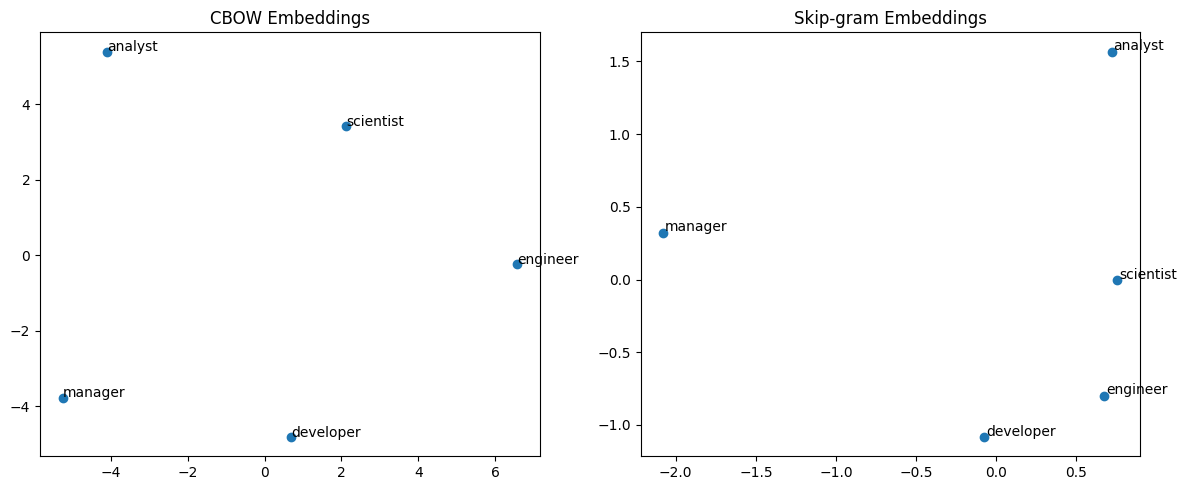

In [87]:

from sklearn.decomposition import PCA


words = ["analyst", "engineer", "scientist", "developer", "manager"]

cbow_vecs = np.vstack([w2v_cbow.wv[w] for w in words])
sg_vecs   = np.vstack([w2v_sg.wv[w]   for w in words])


pca = PCA(n_components=2, random_state=0)
cbow_2d = pca.fit_transform(cbow_vecs)
sg_2d   = pca.fit_transform(sg_vecs)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(cbow_2d[:,0], cbow_2d[:,1])
for i, w in enumerate(words):
    plt.text(cbow_2d[i,0]+0.01, cbow_2d[i,1]+0.01, w)
plt.title("CBOW Embeddings")

plt.subplot(1,2,2)
plt.scatter(sg_2d[:,0], sg_2d[:,1])
for i, w in enumerate(words):
    plt.text(sg_2d[i,0]+0.01, sg_2d[i,1]+0.01, w)
plt.title("Skip-gram Embeddings")

plt.tight_layout()
plt.show()


### Question 27

Based on the graphs above, what would you say are the most similar roles?

In [88]:
print("Most similar roles for CBOW are Scientist and Engineer; then Skip-gram are Engineer and Developer.")


Most similar roles for CBOW are Scientist and Engineer; then Skip-gram are Engineer and Developer.
